In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json


Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"gerrardpinilla","key":"1aab7fc8ed2fb29b7a717394363ccb50"}'}

In [ ]:
!kaggle datasets download kmader/skin-cancer-mnist-ham10000


Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.20G/5.20G [03:10<00:00, 73.1MB/s]
100% 5.20G/5.20G [03:10<00:00, 29.3MB/s]


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip -d /content/ham10000_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: /content/ham10000_dataset/ham10000_images_par

In [ ]:
import os

for root, dirs, files in os.walk("/content/ham10000_dataset"):
    for name in files:
        print(os.path.join(root, name))


/content/ham10000_dataset/HAM10000_metadata.csv
/content/ham10000_dataset/hmnist_8_8_RGB.csv
/content/ham10000_dataset/hmnist_28_28_L.csv
/content/ham10000_dataset/hmnist_28_28_RGB.csv
/content/ham10000_dataset/hmnist_8_8_L.csv
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0029117.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0027865.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0024769.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0024674.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0027021.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0027395.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0026552.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0024581.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0024594.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0027373.jpg
/content/ham10000_dataset/HAM10000_images_part_1/ISIC_0025273.jpg
/content/ham10000_dataset/HAM10000_images_part

In [ ]:
import pandas as pd

metadata_path = "/content/ham10000_dataset/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

image_dir_1 = "/content/ham10000_dataset/ham10000_images_part_1"
image_dir_2 = "/content/ham10000_dataset/ham10000_images_part_2"

image_dict = {
    os.path.splitext(f)[0]: os.path.join(d, f)
    for d in [image_dir_1, image_dir_2]
    for f in os.listdir(d) if f.endswith(".jpg")
}
X, y = [], []

for _, row in df.iterrows():
    image_id = row['image_id']
    label = row['dx']
    path = image_dict.get(image_id)

    if path:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            X.append(img)
            y.append(label)

X = np.array(X) / 255.0
y = LabelEncoder().fit_transform(y)


In [ ]:
from sklearn.model_selection import train_test_split

# Split into train (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - accuracy: 0.6542 - loss: 1.0789 - val_accuracy: 0.6591 - val_loss: 0.9567
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - accuracy: 0.6702 - loss: 0.9316 - val_accuracy: 0.6864 - val_loss: 0.8943
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 43s 187ms/step - accuracy: 0.6873 - loss: 0.8557 - val_accuracy: 0.6964 - val_loss: 0.8509
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 81s 181ms/step - accuracy: 0.7127 - loss: 0.7834 - val_accuracy: 0.7170 - val_loss: 0.7783
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.7322 - loss: 0.7012 - val_accuracy: 0.7210 - val_loss: 0.7998
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 40s 182ms/step - accuracy: 0.7419 - loss: 0.6899 - val_accuracy: 0.7437 - val_loss: 0.7241
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.7548 - loss: 0.6620 - val_accuracy: 0.7410 - val_loss: 0.7513
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.7627 - loss: 0

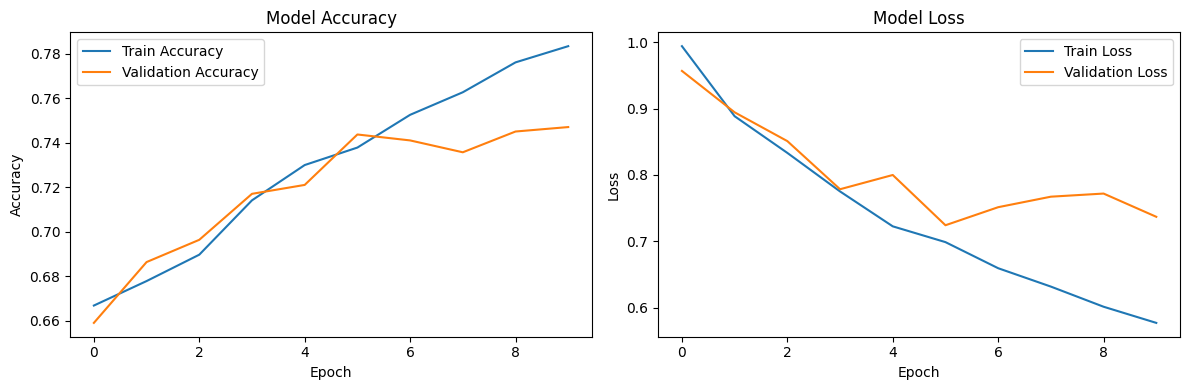

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.pdf")  #Required for Overleaf
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.35      0.33        49
           1       0.46      0.53      0.49        77
           2       0.45      0.36      0.40       165
           3       0.00      0.00      0.00        17
           4       0.42      0.41      0.41       167
           5       0.86      0.90      0.88      1006
           6       1.00      0.27      0.43        22

    accuracy                           0.73      1503
   macro avg       0.50      0.40      0.42      1503
weighted avg       0.72      0.73      0.72      1503



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


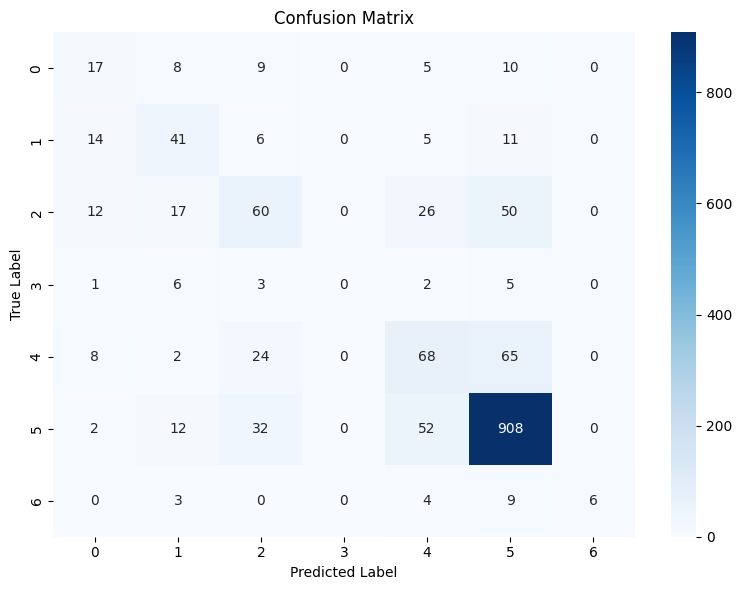

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.pdf")  # Save for Overleaf
plt.show()



 Correct Predictions:


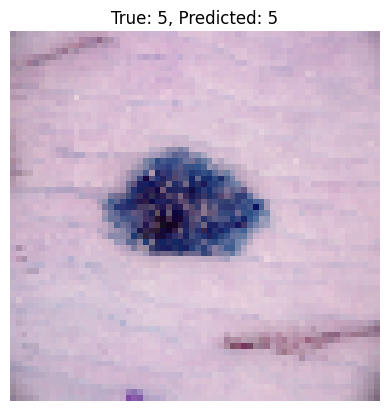

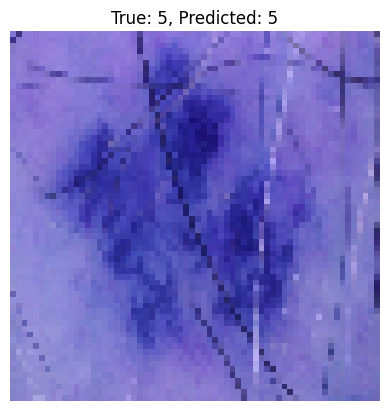

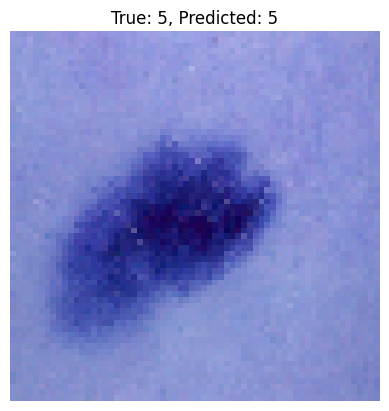


 Incorrect Predictions:


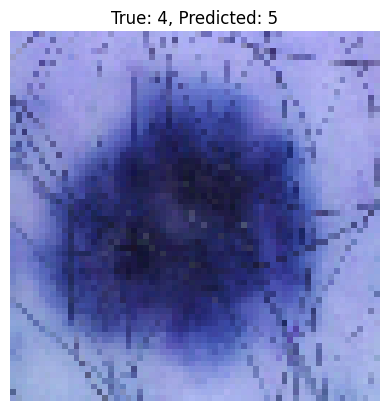

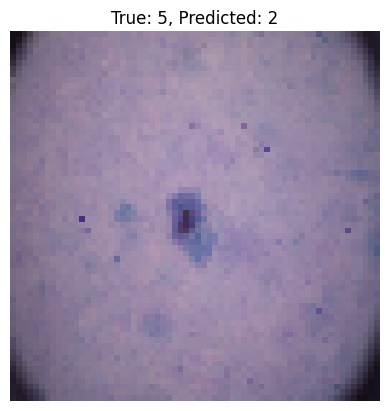

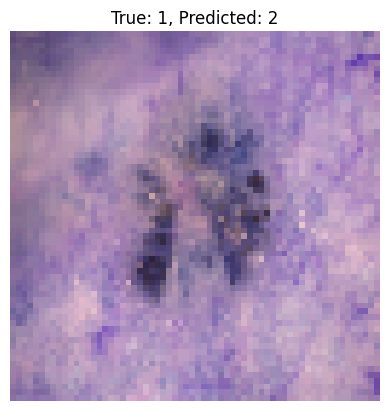

In [ ]:
import random

# Find correctly and incorrectly predicted indices
correct = [i for i in range(len(y_test)) if y_pred[i] == y_test[i]]
incorrect = [i for i in range(len(y_test)) if y_pred[i] != y_test[i]]

# Show 3 correct predictions
print("\n Correct Predictions:")
for i in random.sample(correct, 3):
    plt.imshow(X_test[i])
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred[i]}")
    plt.axis('off')
    plt.show()

# Show 3 incorrect predictions
print("\n Incorrect Predictions:")
for i in random.sample(incorrect, 3):
    plt.imshow(X_test[i])
    plt.title(f"True: {y_test[i]}, Predicted: {y_pred[i]}")
    plt.axis('off')
    plt.show()
